In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import kagglehub
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




Data Collection And Processing.

In [2]:
#Loading the data from csv file to pandas dataframe.
'''# Download latest version
path = kagglehub.dataset_download("nehalbirla/vehicle-dataset-from-cardekho")

print("Path to dataset files:", path)'''
car_dataset = pd.read_csv('/content/CAR DETAILS FROM CAR DEKHO.csv')
car_dataset


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
4335,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
4336,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
4337,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
4338,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


In [3]:
car_dataset.shape

(4340, 8)

In [4]:
car_dataset.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [5]:
car_dataset.isnull().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0


Dropping name column as it contains most of the text data that requires complex processing. It contains a mix of brand/model/variant.
Simple features like year, fuel, etc. already capture valuable info.

In [6]:
car_dataset_cleaned = car_dataset.drop(columns = ['name'])

#Drop any rows with missing values (if any)
car_dataset_cleaned = car_dataset_cleaned.dropna()

Defining Features and Target.

In [7]:
#Define input features (X) and output/ target variable(y)
X = car_dataset_cleaned.drop(columns = ['selling_price'])
y = car_dataset_cleaned['selling_price']
#selling_price is what we want to predict.

In [8]:
#List of numerical and categorical features. We Separate categorical and numerical data for appropriate preprocessing.
categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
numerical_columns = ['year', 'km_driven']

One Hot-Encode Categorical Features.
Categorical data are the data that represents categories or labels - not numbers.
These are textual(non - numeric) columns. Machine Learning models like linear or lasso regression can't process text directly, they require numerical inputs. We can replace categories with numbers but it isn't much effiecient where ranking can take place between the fuels and etc.
That's wrong as there shouldn't be any order or ranking among the fuel types.

For this , One-Hot Encoding is the solution where it creates a separate column for each category , and uses 0 or 1 to show whether a row belongs to that category.

-> ColumnTransformer(...) is a scikit-learn tool that allows us to apply different preprocessing steps to different columns in our dataset.

-> transformers = [...] . This is a list of transformations you are telling the ColumnTransformer to apply.

-> remainder = 'passthrough' tell the ColumnTransformer ,"For all other columns not listed in categorical_columns, just pass them through (keep them as they are)."

In [9]:
#Preprocessor for encoding categorical data.
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first'), categorical_columns)
    ], remainder = 'passthrough')

Splitting the Data.

In [10]:
#Splitting the data into train and test splits.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)
Xtrain

,year,km_driven,fuel,seller_type,transmission,owner
227,2017,20000,Diesel,Individual,Manual,First Owner
964,2018,50000,Diesel,Individual,Manual,First Owner
2045,2013,25000,Petrol,Individual,Manual,Second Owner
1025,2011,70000,Diesel,Individual,Manual,First Owner
4242,2017,72000,Diesel,Dealer,Manual,First Owner
...,...,...,...,...,...,...
3444,2006,50000,Diesel,Individual,Manual,First Owner
466,2011,80000,Diesel,Individual,Manual,First Owner
3092,2016,51000,Diesel,Dealer,Manual,First Owner
3772,2013,80000,Diesel,Individual,Manual,First Owner


Linear Regression Model.

-> Creates a pipeline -- a sequence of steps to run automatically.

1. preprocessor - this handles things like one-hot encoding your categorical columns.
2. LinearRegression() - this trains a linear regression model to find relationships between features and price.

In [11]:
linear_reg_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                        ('regressor', LinearRegression())])
#Train the Linear Regression Model.
linear_reg_pipeline.fit(Xtrain, Ytrain)

#predict using the test set.
y_pred_linear = linear_reg_pipeline.predict(Xtest)


Lasso Regression Model.

Uses Lasso Regression instead of Linear Regression.
alpha = 1.0 controls the strength of regularization.

In [12]:
lasso_reg_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                       ('regressor', Lasso(alpha = 1.0))])

#Train the lasso model.
lasso_reg_pipeline.fit(Xtrain, Ytrain)

#Predict using the test set.
y_pred_lasso = lasso_reg_pipeline.predict(Xtest)

Standard Linear Regression tries to:
--> Minimize error (how far predictions are from real prices)

Lasso Regression tries to :
--> Minimize error + penalize big/complex coefficients.

Evaluating the models.



In [13]:
#Function to print evaluation metrics.
def evaluate_model(y_true, y_pred, model_name):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  print(f"Evaluation Metrics for {model_name}:")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R2 Score: {r2:.2f}")
  print('-'*25)

#Evaluate both models.
evaluate_model(Ytest, y_pred_linear, 'Linear Regression')
evaluate_model(Ytest, y_pred_lasso, 'Lasso Regression')


Evaluation Metrics for Linear Regression:
MSE: 182146878750.38
RMSE: 426786.69
R2 Score: 0.40
-------------------------
Evaluation Metrics for Lasso Regression:
MSE: 182146567679.69
RMSE: 426786.33
R2 Score: 0.40
-------------------------


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")

# Feature Engineering
df.dropna(inplace=True)
# Create 'brand' column from 'name'
df['brand'] = df['name'].apply(lambda x: x.split()[0])
# Create 'car_age' column
df['car_age'] = 2025 - df['year']
# Drop original 'name' and 'year' columns
df.drop(columns=['name', 'year'], inplace=True)

# Define X and y AFTER feature engineering
X = df.drop(columns='selling_price')
y = df['selling_price']

# Categorical columns (now includes 'brand')
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']
# Numerical columns (now includes 'car_age')
numerical_cols = ['km_driven', 'car_age'] # Added car_age here as it's numerical

# Preprocessor: Define and fit AFTER defining X and y
# Ensure all relevant columns (categorical and numerical) are handled
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols), # Added handle_unknown='ignore'
    ('num', 'passthrough', numerical_cols) # Explicitly pass through numerical columns
], remainder='passthrough') # Remainder will handle any other columns not specified

# Split data AFTER defining X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression: Define, Train, and Predict in the same block
lin_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Use the preprocessor defined above
    ('regressor', LinearRegression())
])
lin_reg_pipeline.fit(X_train, y_train)
y_pred_lin = lin_reg_pipeline.predict(X_test)

# Lasso Regression: Define, Train, and Predict in the same block
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Use the preprocessor defined above
    ('regressor', Lasso(alpha=1.0))
])
lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)

# Evaluation function (can remain as is)
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"MSE: ₹{mse:.2f}")
    print(f"RMSE: ₹{rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print('-' * 30)

# Evaluate both models
evaluate_model(y_test, y_pred_lin, "Linear Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

Linear Regression Results:
MSE: ₹162768944832.70
RMSE: ₹403446.33
R² Score: 0.4666
------------------------------
Lasso Regression Results:
MSE: ₹143449691342.73
RMSE: ₹378747.53
R² Score: 0.5299
------------------------------


Now there is a small change between the accuracy scores of two models and also there aren't much efficient model as the scores are not upto the mark as expected.

Now for that after researching, Going for the XGBoost algorithm is better for much efficiency and also it is very much suitabe for our dataset(Obtained from kaggle).

How It Works (Simple Terms):
--> Start with a bad model (like predicting the average).

--> Find the errors (residuals) from this prediction.

--> Train a new decision tree to predict those errors.

--> Add this new tree to the old model to improve it.

--> Repeat steps 2–4 many times.

--> Combine all the trees together — the result is much more accurate.

In [16]:
#going with XGBoost Algorithm.

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load dataset
df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")
df.dropna(inplace=True)

In [18]:
# Feature engineering
df['brand'] = df['name'].apply(lambda x: x.split()[0])
df['car_age'] = 2025 - df['year']
df.drop(columns=['name', 'year'], inplace=True)

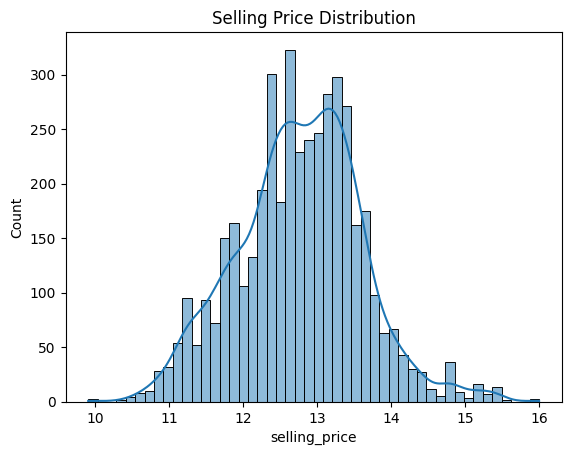

Skewness: 0.06017265586710223


In [24]:
#Optional: Check skewness
sns.histplot(df['selling_price'], kde = True)
plt.title("Selling Price Distribution")
plt.show()
print("Skewness:", df['selling_price'].skew())



In [34]:
#Optional: Apply log transformation if skewness > 1
log_transform = df['selling_price'].skew() > 1
if log_transform:
  df['selling_price'] = np.log1p(df['selling_price'])

#Define features and target
X = df.drop(columns = ['selling_price'])
y = df['selling_price']

categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']
numerical_cols = ['km_driven', 'car_age']

#this transformation smooths out extreme values, bringing the distribution closer to normal, which is better for many ML models.

ColumnTransformer in scikit-learn allows us to apply different preprocessing steps to different columns of our dataset in one clean, organized way.

This is especially useful when our dataset has:

--> Categorical features (like 'fuel', 'brand')

--> Numerical features (like 'km_driven', 'car_age')

In [35]:
#preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'), categorical_cols),#this line says for the categorical cols apply -
    #- HotEncoder to turn each category into binary features.
    ('num', 'passthrough', numerical_cols) # this line specifies that for the numerical columns , don't do anything -- just pass through -
    #- them as they are.
])



handle_unknown = 'ignore' : if a new category appears during prediction that wasn't seen during training, just ignore it(instead of erroring out).

'passthrough' tells it to leave these columns unchanged.

In [36]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [37]:
#XGBoost pipeline.
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators = 100,
        learning_rate = 0.1,
        max_depth = 6,
        random_state = 42,
        n_jobs = -1
    ))
])
#Train and Predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)



In [40]:
#If log_transformed, revert prediction for comparison
if log_transform:
  y_test = np.expm1(y_test)
  y_pred_xgb = np.expm1(y_pred_xgb)


In [42]:
#Evaluation
def evaluate_model(y_true, y_pred, model_name):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  print(f"{model_name} Results:")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R² Score: {r2:.4f}")
  print('-' * 30)

evaluate_model(y_test, y_pred_xgb, "XGBoost Regression")


XGBoost Regression Results:
MSE: 0.12
RMSE: 0.35
R² Score: 0.8196
------------------------------


Why XGBoost is Suitable for Car Price Prediction:

High R² Score (0.82)
→ The model explains about 82% of the variation in car prices, which is excellent for predictive modeling.

Low RMSE (0.35)
→ The average prediction error is low, especially when considering the prices were log-transformed. This indicates accurate predictions.

Handles Non-Linearity
→ XGBoost can capture complex, non-linear relationships in the data — which car pricing typically involves (e.g., brand, mileage, age, fuel type interactions).

Resistant to Overfitting
→ With tuning (like n_estimators, max_depth, etc.), XGBoost generalizes well to new, unseen data, reducing the risk of overfitting.

Scales Well
→ XGBoost is fast and efficient, making it suitable for large datasets or real-time applications like used car pricing engines.

